# Quantum Arithmetic using QFT.

Draper addition - https://arxiv.org/pdf/quant-ph/0008033

Addition and multiplication - https://arxiv.org/pdf/1411.5949

In [82]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit import transpile

In [83]:
# Pauli Gates as custom quantum operations
pauli_gates = {'X': Gate("x", 1, []), 'Y': Gate("y", 1, []), 'Z': Gate("z", 1, [])}

def add_noise(circuit, alpha, beta):
    noisy_circuit = QuantumCircuit(circuit.num_qubits)
    for instr, qargs, _ in circuit:
        noisy_circuit.append(instr, qargs)
        noise_prob = alpha if instr.num_qubits == 1 else beta
        if np.random.rand() < noise_prob:
            noise_gate = pauli_gates[np.random.choice(['X', 'Y', 'Z'])]
            noisy_circuit.append(noise_gate, [qargs[0]])
    return noisy_circuit

In [85]:
def transform_to_basis(circuit):
    basis = ['cx', 'id', 'rz', 'sx', 'x']
    return transpile(circuit, basis_gates=basis)

In [86]:
# write qft function from scratch
def qft(circuit):
    n = circuit.num_qubits
    for i in range(n):
        circuit.h(i)
        for j in range(i + 1, n):
            circuit.cp(np.pi / 2**(j - i), j, i)
        circuit.barrier()
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)

        # write iqft function from scratch
def iqft(circuit):
    n = circuit.num_qubits
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)
    for i in range(n - 1, -1, -1):
        circuit.barrier()
        for j in range(i - 1, -1, -1):
            circuit.cp(-np.pi / 2**(i - j), i, j)
        circuit.h(i)

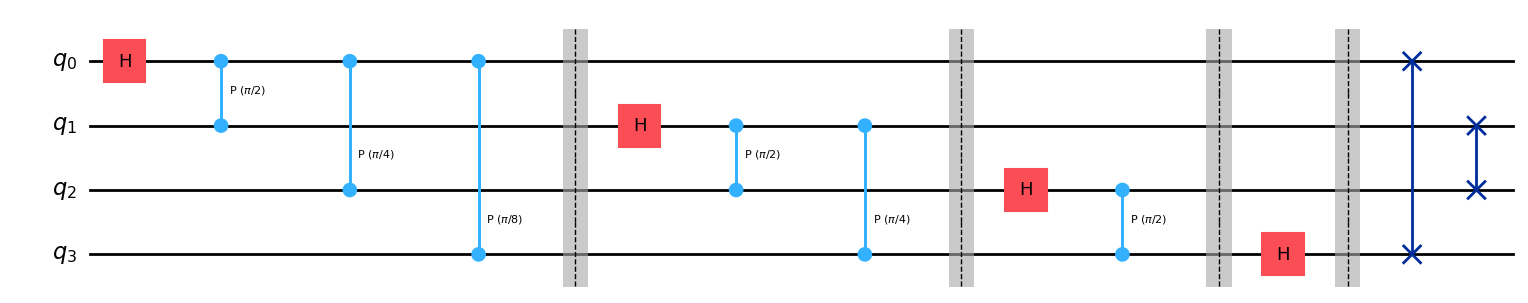

In [87]:
#example = QuantumCircuit(4)
qft(QuantumCircuit(4))
example.draw('mpl')

QFT circuit works ! No let's check for IQFT circuit

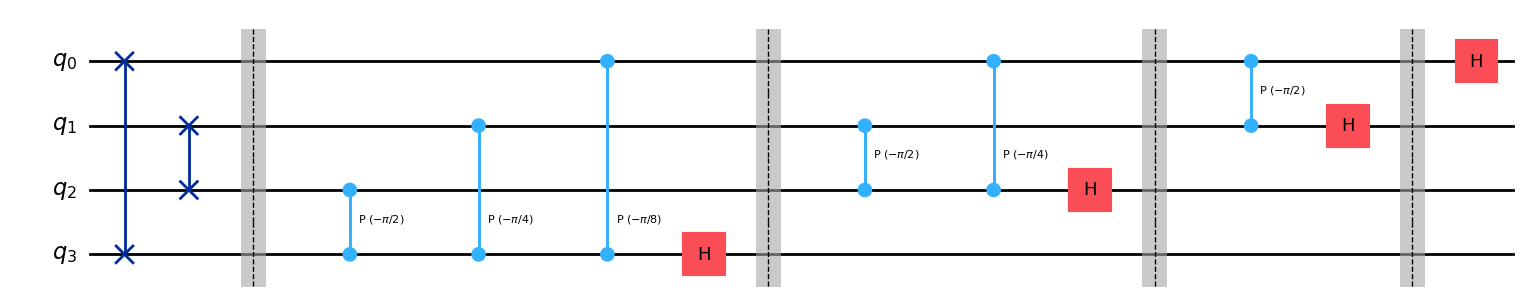

In [88]:
#example_iqft = QuantumCircuit(4)
iqft(QuantumCircuit(4))
example_iqft.draw('mpl')

IQFT circuit also works! Now let's build the summing circuit based on the draper addition paper.

In [64]:
# circuit formation for addition
def quantum_sum(a, b, n):
    circuit = QuantumCircuit(2 * n)
    for i in range(n):
        if (a >> i) & 1:
            circuit.x(i)
        if (b >> i) & 1:
            circuit.x(i + n)
    qft(circuit, n)
    for i in range(n):
        circuit.cx(i + n, i)
    inverse_qft(circuit, n)
    return circuit

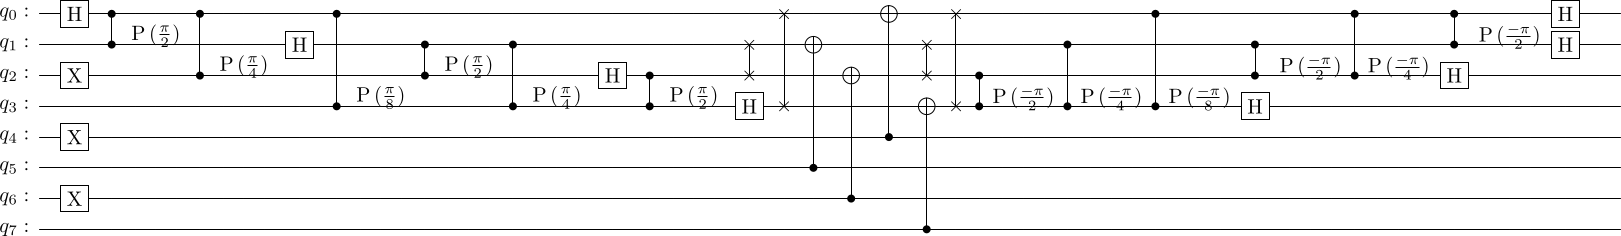

In [18]:
qc = quantum_sum(4, 5, 4)
transformed_qc = transform_to_basis(qc)
noisy_qc = add_noise(transformed_qc, alpha=0.05, beta=0.1)

qc.draw('latex')

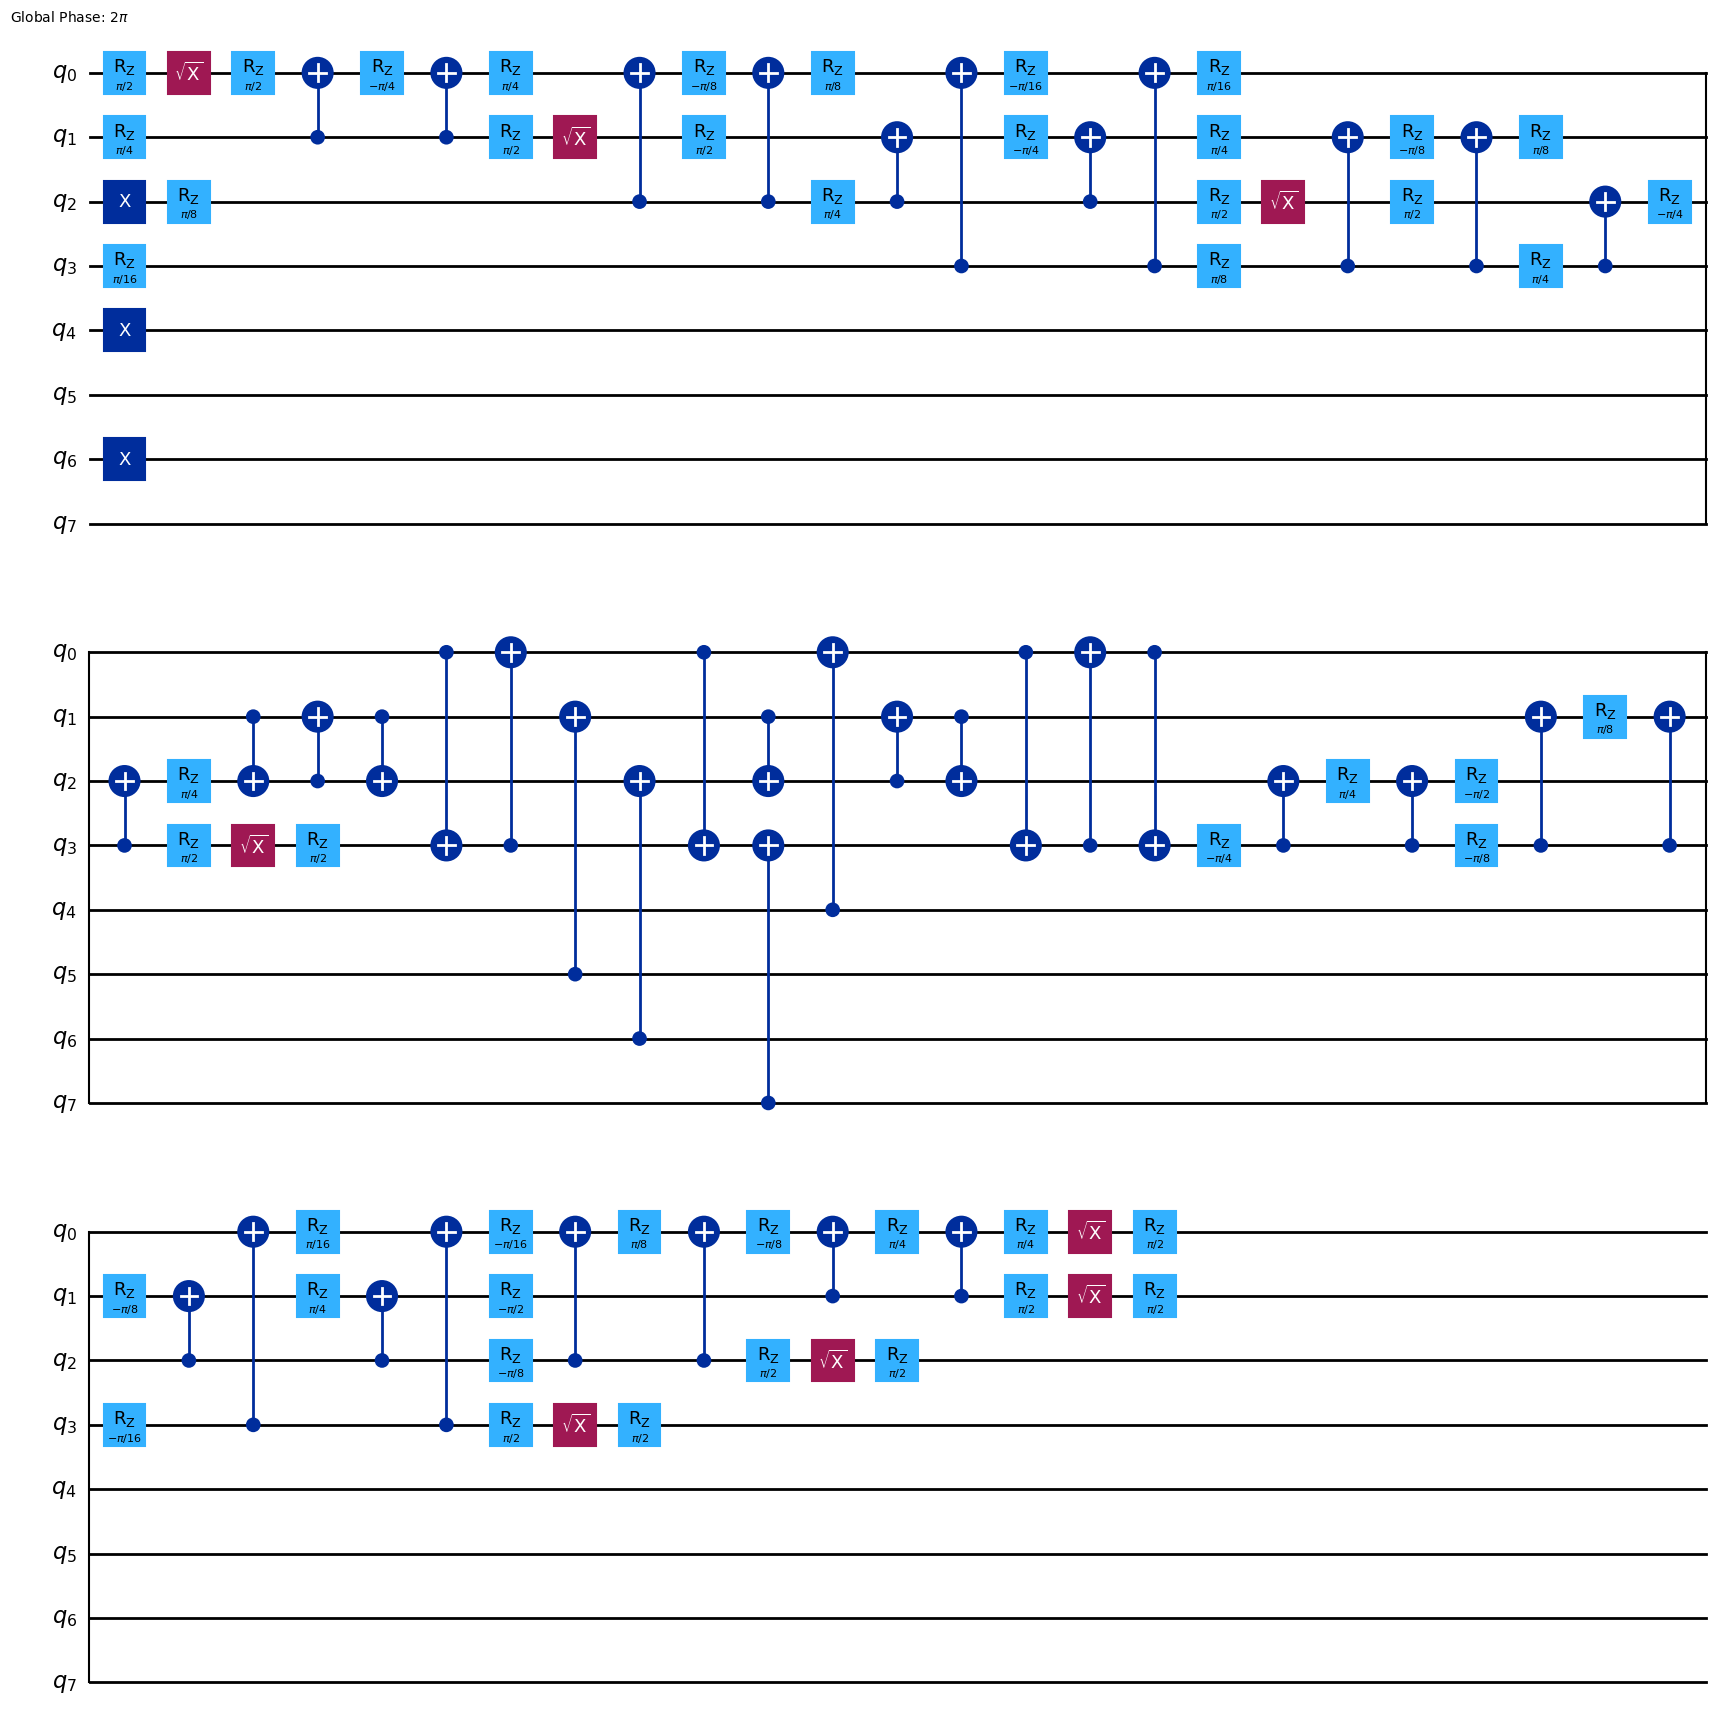

In [21]:
transformed_qc.draw('mpl')

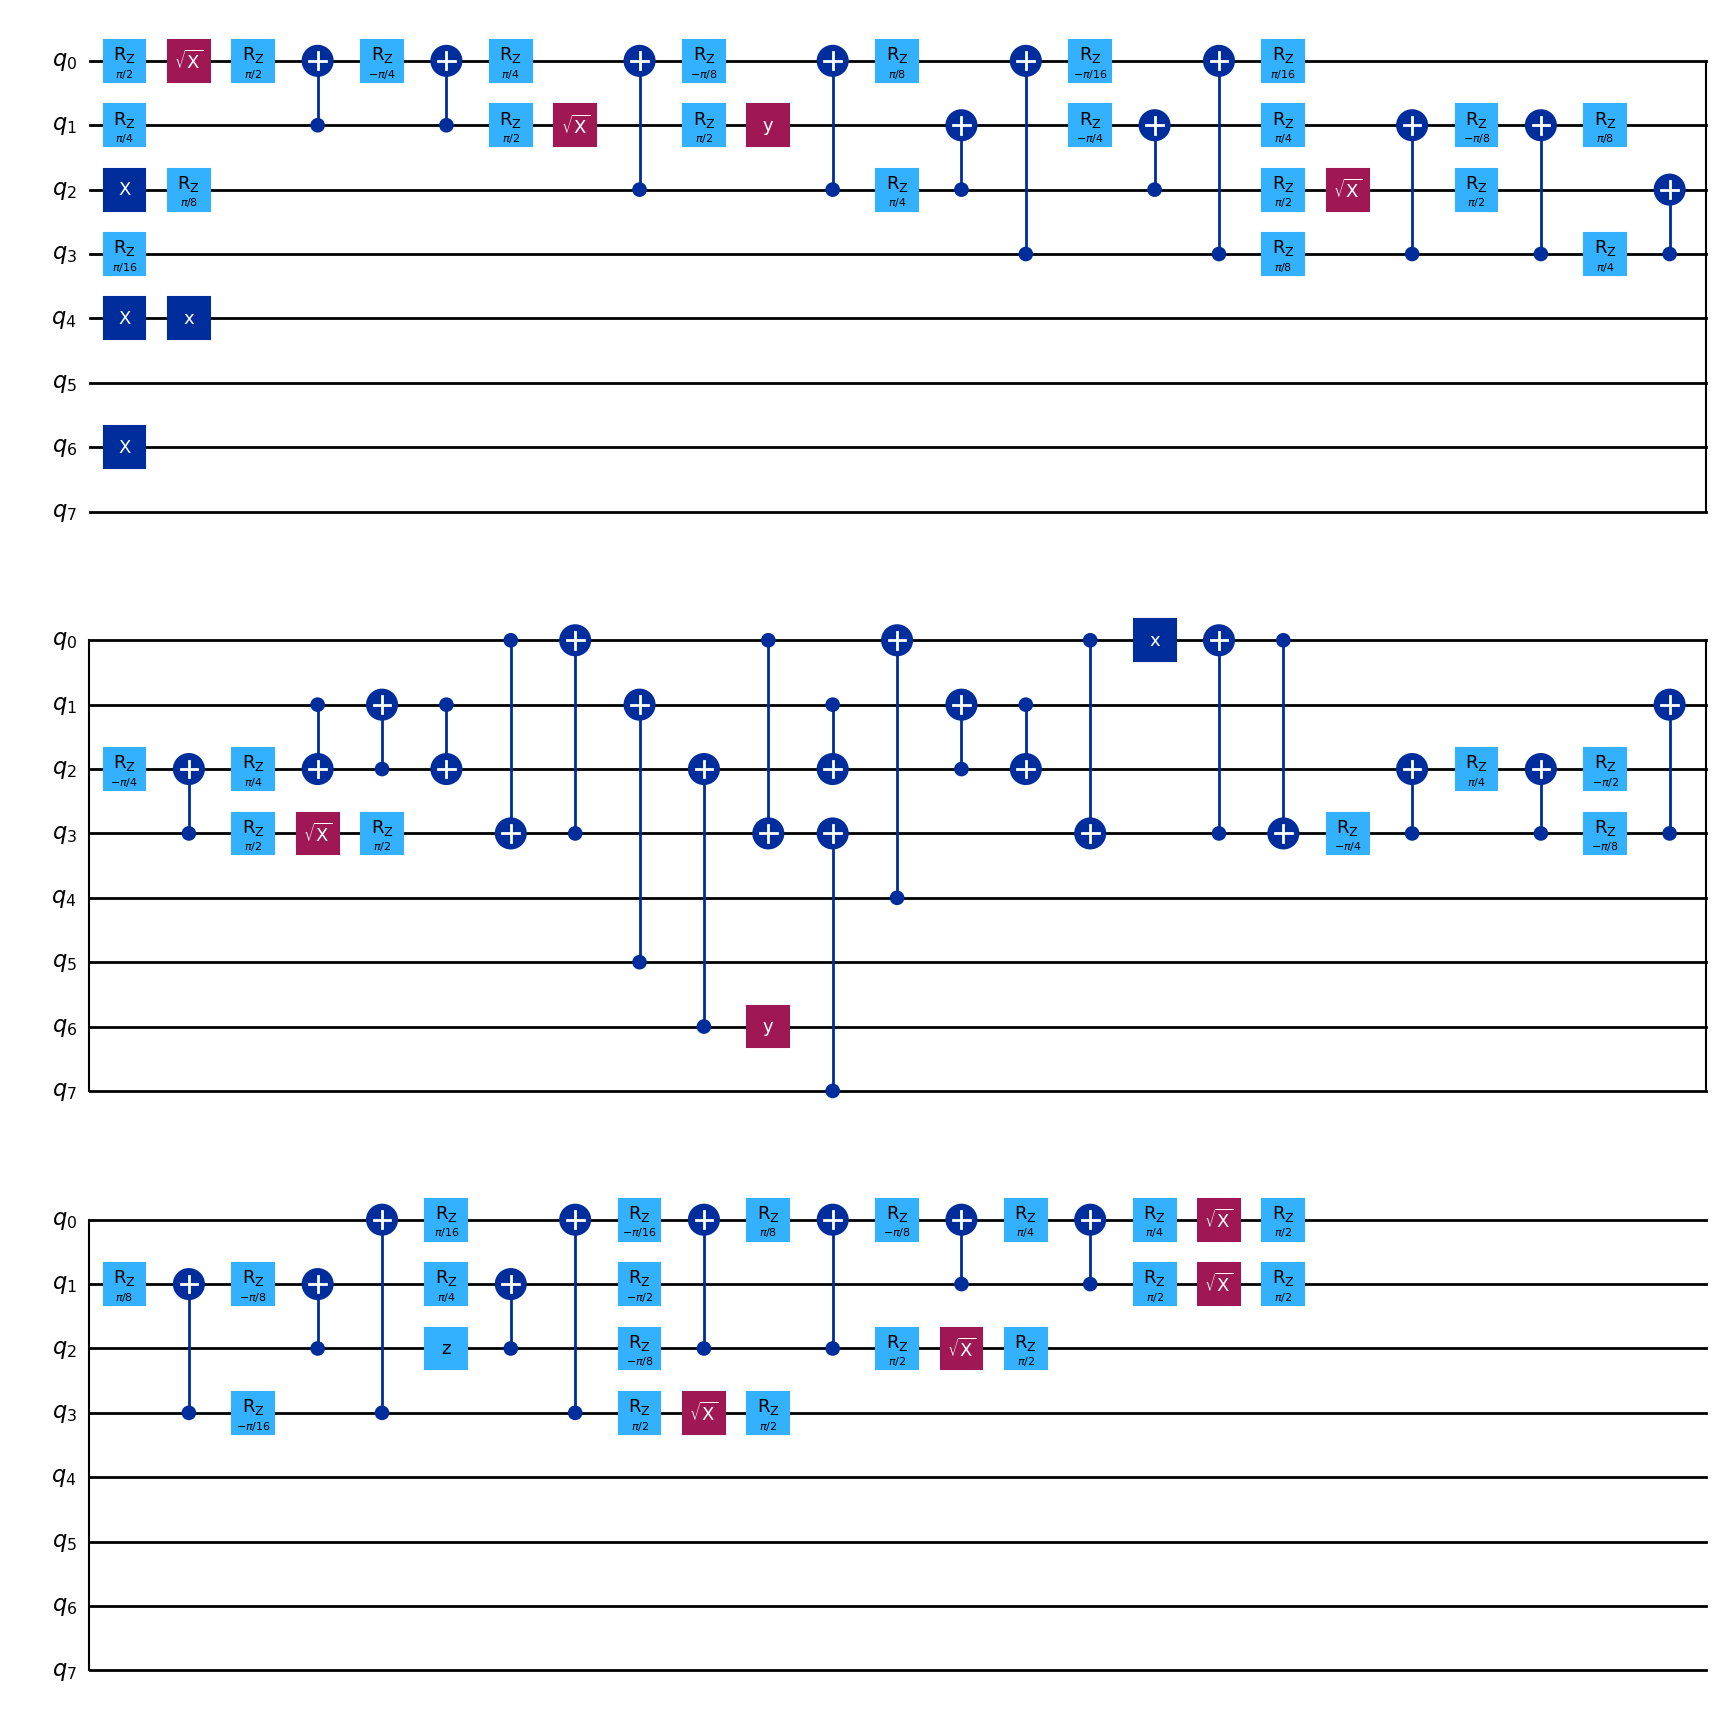

In [22]:
noisy_qc.draw('mpl')

In [4]:
import qiskit.quantum_info as qi
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorSampler
#from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#from qiskit.visualization import plot_histogram
#from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

# Example circuit with a = 1, b = 1, n = 2
qc = quantum_sum(1, 1, 2)
job = transpile(RealAmplitudes(num_qubits=2, reps=3), sim, optimization_level=0)
# Convert to gate basis and add noise
transformed_qc = transform_to_basis(qc)
noisy_qc = add_noise(transformed_qc, alpha=0.05, beta=0.1)

# Simulation and analysis
sim = AerSimulator() # set up simulator
pqc = transpile(pqc, sim, optimization_level=0)

sampler = SamplerV2()

from qiskit_ibm_runtime import QiskitRuntimeService
provider = QiskitRuntimeService(channel='ibm_quantum', token="set your own token here")
backend = provider.get_backend("ibm_kyoto")

backend = qiskit.Aer.get_backend('statevector_simulator')
state_no_noise = qi.Statevector.from_instruction(transformed_qc).probabilities_dict()
state_with_noise = qi.Statevector.from_instruction(noisy_qc).probabilities_dict()

# Print Results
print("State without noise:", state_no_noise)
print("State with noise:", state_with_noise)


NameError: name 'qiskit' is not defined

In [ ]:
from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

sim = AerSimulator()
# --------------------------
# Simulating using sampler
# --------------------------
from qiskit_aer.primitives import SamplerV2
from qiskit import QuantumCircuit

# create a Bell circuit
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

# create two parameterized circuits
pqc = RealAmplitudes(num_qubits=2, reps=2)
pqc.measure_all()
pqc = transpile(pqc, sim, optimization_level=0)
pqc2 = RealAmplitudes(num_qubits=2, reps=3)
pqc2.measure_all()
pqc2 = transpile(pqc2, sim, optimization_level=0)

theta1 = [0, 1, 1, 2, 3, 5]
theta2 = [0, 1, 2, 3, 4, 5, 6, 7]

# initialization of the sampler
sampler = SamplerV2()

# collect 128 shots from the Bell circuit
job = sampler.run([bell], shots=128)
job_result = job.result()
print(f"counts for Bell circuit : {job_result[0].data.meas.get_counts()}")
 
# run a sampler job on the parameterized circuits
job2 = sampler.run([(pqc, theta1), (pqc2, theta2)])
job_result = job2.result()
print(f"counts for parameterized circuit : {job_result[0].data.meas.get_counts()}")

# --------------------------------------------------
# Simulating with noise model from actual hardware
# --------------------------------------------------
from qiskit_ibm_runtime import QiskitRuntimeService
provider = QiskitRuntimeService(channel='ibm_quantum', token="set your own token here")
backend = provider.get_backend("ibm_kyoto")

# create sampler from the actual backend
sampler = SamplerV2.from_backend(backend)

# run a sampler job on the parameterized circuits with noise model of the actual hardware
bell_t = transpile(bell, AerSimulator(basis_gates=["ecr", "id", "rz", "sx"]), optimization_level=0)
job3 = sampler.run([bell_t], shots=128)
job_result = job3.result()
print(f"counts for Bell circuit w/noise: {job_result[0].data.meas.get_counts()}")